# Using RoBERTa with fast ai 

This notebook follows the tutorial @ https://medium.com/@devkosal/using-roberta-with-fastai-for-nlp-7ed3fed21f6c

In [1]:
import os
__print__ = print
def print(string):
    os.system(f'echo \"{string}\"')
    __print__(string)

In [2]:
! pip install pytorch-transformers

     |████████████████████████████████| 184kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 890kB 8.5MB/s eta 0:00:01     |██████████████████████████▊     | 737kB 8.5MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=934ea93517316162dd46f0c07dec3b3a888c9ca48143b9ba06a669af9305413c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# import Fastai tools
from fastai.text import *
from fastai.metrics import *

# import roberta's tokenizer 
from pytorch_transformers import RobertaTokenizer

In [4]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=4, 
    max_seq_len=256, 
    num_labels = 13,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

## data preprocessing 

In [5]:
#df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df = pd.read_csv("/kaggle/input/query_result.csv")
#if config.testing: df = df[:5000]
df.shape

(5000, 4)

In [7]:
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

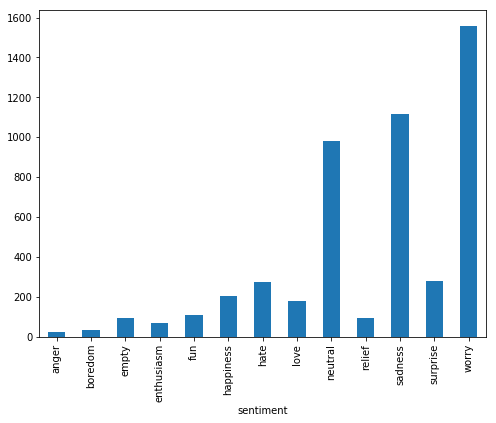

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('sentiment').content.count().plot.bar(ylim=0)
plt.show()

In [9]:
df.head(3)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...


15254


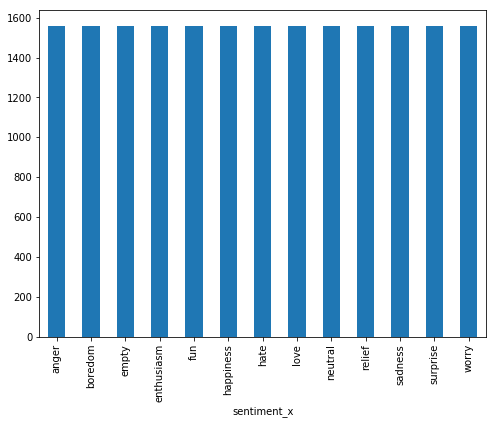

In [47]:
# Using oversampling to avoid information lose
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['sentiment_L'] = le.fit_transform(df['sentiment'])
df.head(3)

X = df[['content','sentiment']]
y_L = df.sentiment_L
X_train, X_test, y_L_train, y_L_test = train_test_split(X, y_L, test_size=0.3, random_state = 42)

import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(X, y_L)

print(X_ros.shape[0] - X.shape[0])


import pandas as pd
from pandas import DataFrame
X_ros = DataFrame(X_ros, columns = ['content', 'sentiment'])
y_ros = DataFrame(y_ros, columns = ['sentiment'])
X_ros.index.name = 'id'
y_ros.index.name = 'id'
train_ros = pd.merge(X_ros,
                    y_ros,
                    how = 'left',
                    on = 'id')
train_ros.head(3)

# plot balanced
fig = plt.figure(figsize=(8,6))
train_ros.groupby('sentiment_x').content.count().plot.bar(ylim=0)
plt.show()

In [64]:
ros

RandomOverSampler(random_state=None, ratio=None, return_indices=False,
                  sampling_strategy='auto')

In [ ]:
print(X_ros.shape[0] - X.shape[0], 'new random picked points %s')
#'accuracy %s' % accuracy_score(y_pred, y_test)

In [56]:
#feat_cols = "review"
#label_cols = "sentiment"
feat_cols = "content"
label_cols = "sentiment_x"

## Setting Up the Tokenizer

In [49]:
# create a fastai wrapper around RodertaTokenizer
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [50]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")
# initialize Fastai tokenizer ( we have to wrap out Fastai wrapper within the tokenizer class for fastai compatibility )
fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

100%|██████████| 456318/456318 [00:00<00:00, 495566.14B/s]


In [51]:
# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [52]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

## Setting up the DataBunch

In [53]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [54]:
# build a roberta specific Textlist class 
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [57]:
# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

# creating our databunch 
data = RobertaTextList.from_df(train_ros, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

# Building the Model

In [58]:
import torch
import torch.nn as nn
from pytorch_transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=13):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [59]:
roberta_model = CustomRobertaModel()

learn = Learner(data, roberta_model, metrics=[accuracy])

100%|██████████| 501200538/501200538 [00:43<00:00, 11609724.19B/s]


In [60]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.895154,0.812403,0.740988,04:23


# Getting Predictions

In [61]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [62]:
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [63]:
# accuracy on valid
(pred_values == data.valid_ds.y.items).mean()

0.7409876543209877